In [1]:
import os
import numpy as np 

from plot_params import * 
from math import sqrt
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import qmc, shapiro, norm, f

In [2]:
# define global functions

def check_inside_mandlebrot(i, c):
    z = 0 + 0j
    for _ in range(i):
        z = z ** 2 + c
        if abs(z) > 2:
            return 0
    return 1

def mandlebrot_area(i, s, sampling_function):
    random_complex_numbers = sampling_function(s)
    in_mandlebrot = 0
    for z in random_complex_numbers:
        in_mandlebrot += check_inside_mandlebrot(i, z)
    area = in_mandlebrot / s * area_box
    return area

def uniform_samples(n):
    real = np.random.uniform(real_min, real_max, size=n)
    imaginary = np.random.uniform(imag_min, imag_max, size=n) * 1j
    random_complex_numbers = real + imaginary
    return random_complex_numbers

def OLHC_samples(n):
    M = int(np.sqrt(n))
    scale = 4/n
    x = np.zeros(shape=(M,M))
    y = np.zeros(shape=(M,M))
    m = 0
    samples = np.zeros(n,dtype=np.complex_)
    for i in range(M):
        for j in range(M):
            m = m + 1
            x[i,j] = m
            y[i,j] = m
            
    for i in range(M):
        x[:,i] = permute(x[:,i],M)
        y[:,i] = permute(y[:,i],M)
 
    for i in range(M):
        for k in range(M):
            reals = -2 + scale*(x[i,k] + np.random.random(1))
            imags = -2 + scale*(y[i,k] + np.random.random(1))
            samples[M*i+k] = reals + imags*1j
    return samples

def permute(x, N):
    for i in reversed(range(1,N-1)):
        h = x[i]
        r = np.random.randint(N)
        x[i] = x[r]
        x[r] = h
    return x

def LHC_samples(n):
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=n) 
    sample = qmc.scale(sample, [real_min, imag_min], [real_max, imag_max])
    reals = sample[:, 0]
    imags = sample[:, 1]
    samples = reals + imags * 1j
    return samples

def f_test(data_X, data_Y):
    '''H0: var(x)=var(y).
    returns the p value of the test
    if p > significance level, then H0 is accepted
    this test is sensitive to data_x and data_y '''
    var_x = np.var(data_X)
    var_y = np.var(data_Y)
    n_x = len(data_X)
    n_y = len(data_Y)
    if var_x/var_y > var_y/var_x:
        f_stat = var_x/var_y
        df1 = n_x - 1
        df2 = n_y - 1
    else:
        f_stat = var_y/var_x
        df1 = n_y - 1
        df2 = n_x - 1
    p_value = f.sf(f_stat, df1, df2)
    return p_value


In [3]:
class DetermineNumberRuns():
    def __init__(self, n_samples, default_i, interval_length, z_value, rand_num_generator):
        self.n_samples = n_samples
        self.default_i = default_i
        self.interval_length = interval_length
        self.z_value = z_value
        self.rand_num_generator = rand_num_generator
        
        self.all_areas = []
        self.all_sample_means = []
        self.all_stop_checks = []
        self.all_k_at_check = []

        self.k = 1
        self.sample_mean = 0
        self.sample_var = 0
        self.sample_std = 0
    
    def generate_new_values(self, n_values):
        areas = Parallel(n_jobs=n_cores)(delayed(mandlebrot_area)(self.default_i, self.n_samples, self.rand_num_generator) for _ in range(n_values))
        self.all_areas = self.all_areas + areas
        areas = np.array(self.all_areas)

        self.k += n_values
        self.sample_mean = areas.mean()
        self.sample_var = ((areas - self.sample_mean) ** 2).sum() / (self.k - 1)
        self.sample_std = sqrt(self.sample_var)

    def keep_going(self):
        check = 2 * self.z_value * self.sample_std / sqrt(self.k)
        self.all_stop_checks.append(check)
        self.all_k_at_check.append(self.k)
        return check > self.interval_length
    

In [4]:
# see how fast the area converges based on the number of iterations

class Convergence():
    def __init__(self, max_i, max_s, n_runs, rand_num_generator):
        self.max_i = max_i
        self.max_s = max_s
        self.n_runs = n_runs
        self.rand_num_generator = rand_num_generator
        self.areas = 0
        self.max_mean, self.max_std = self.determine_area(max_i, max_s)
        self.min_mean, self.min_std = self.determine_area(min_i, min_s)
        self.means = []
        self.stds = []
        print(f'best estimation: {self.max_mean} ± {self.max_std}')

    def determine_area(self, i, s):
        areas = Parallel(n_jobs=n_cores)(delayed(mandlebrot_area)(i, s, self.rand_num_generator) for _ in range(self.n_runs))
        areas = np.array(areas)
        self.areas = areas
        mean = areas.mean()
        var = ((areas - mean) ** 2).sum() / (self.n_runs - 1)
        std = sqrt(var)
        return mean, std
    
    def diff_with_max(self, i, s):
        mean, std = self.determine_area(i, s)
        mean_diff = mean - self.max_mean
        std_diff = std + self.max_std
        return mean_diff, std_diff

In [5]:
# sampling area
real_min = -2
real_max = 2
imag_min = -2
imag_max = 2
area_box = (real_max - real_min) * (imag_max - imag_min)

# settings 
n_cores = os.cpu_count()
rand_num_generator = uniform_samples
# n_samples = 1000
n_runs = 100
# interval_length = 0.05
# z_value = 1.96
# n_init_runs = 100
min_i = 10
max_i = 20
n_different_i = 10
min_s = 100
max_s = 400
n_different_s = 10

# lists for looping
i_values = np.linspace(max_i, min_i, n_different_i, dtype=int)
s_values = np.linspace(max_s, min_s, n_different_s, dtype=int)

stds_s = np.zeros(n_different_s)
means_i = np.zeros(n_different_i)
stds_i = np.zeros(n_different_i)

In [6]:
areas_min_all_results = []
areas_max_all_results = []
stds_s_all_results = []
means_i_all_results = []
stds_i_all_results = []

for rand_num_generator in [uniform_samples, LHC_samples, OLHC_samples]:

    stds_s = np.zeros(n_different_s)
    means_i = np.zeros(n_different_i)
    stds_i = np.zeros(n_different_i)

    con = Convergence(max_i, max_s, n_runs, rand_num_generator)
    areas_max = con.areas
    areas_max_all_results.append(areas_max)
    con.determine_area(min_i, min_s)
    areas_min = con.areas
    areas_min_all_results.append(areas_min)

    for m in tqdm(range(n_different_s), desc=rand_num_generator.__name__ + ' s convergence'):
        s = s_values[m]
        _, stds_s[m] = con.determine_area(min_i, s)

    for m in tqdm(range(n_different_i), desc=rand_num_generator.__name__ + ' i convergence'):
        i = i_values[m]
        means_i[m], stds_i[m] = con.diff_with_max(i, max_s)

    stds_s_all_results.append(stds_s)
    means_i_all_results.append(means_i)
    stds_i_all_results.append(stds_i)

best estimation: 1.6996000000000004 ± 0.2685084879120362


uniform_samples i convergence: 100%|██████████| 10/10 [00:00<00:00, 10.99it/s]


best estimation: 1.7516 ± 0.17936318327670123


LHC_samples i convergence: 100%|██████████| 10/10 [00:00<00:00, 11.38it/s]


best estimation: 1.7339999999999998 ± 0.1845223153130397


OLHC_samples i convergence: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Uniform is normal distributed with p=0.21538597345352173
Latin hypercube is normal distributed with p=0.206621915102005
Orthogonal is NOT normal distributed with p=0.009998749941587448


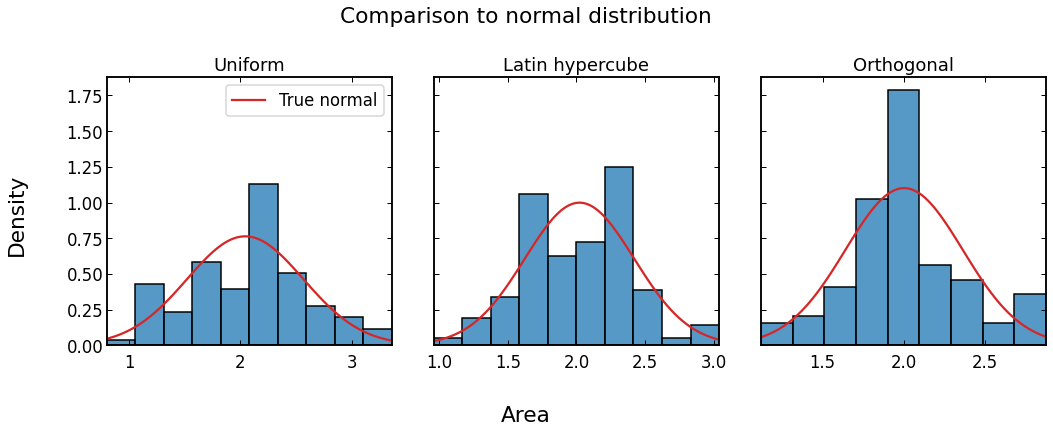

In [7]:
# plot to see if uniform distributed

sampling_names = ['Uniform', 'Latin hypercube', 'Orthogonal']
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
plt.suptitle('Comparison to normal distribution')
fig.supxlabel('Area')
fig.supylabel('Density')

for ax, areas, name in zip(axs, areas_min_all_results, sampling_names):
    x = np.linspace(min(areas), max(areas), 100)
    y = norm.pdf(x, areas.mean(), areas.std())
    ax.plot(x, y, label='True normal', color='tab:red')
    ax.set(xlim=(min(areas), max(areas)), ylabel=' ', title=name)
    sns.histplot(areas, stat='density', ax=ax)

    stat, p = shapiro(areas)
    if p > 0.05:
        print(f'{name} is normal distributed with p={p}')
    else:
        print(f'{name} is NOT normal distributed with p={p}')

axs[0].legend()
axs[0].set_title('Uniform')
axs[1].set_title('Latin hypercube')
axs[2].set_title('Orthogonal')
fig.tight_layout()
plt.show()

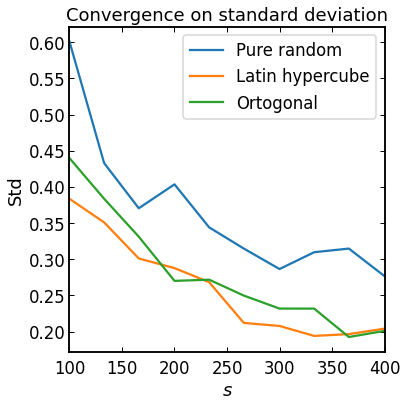

In [8]:
plt.plot(s_values, stds_s_all_results[0], label='Pure random')
plt.plot(s_values, stds_s_all_results[1], label='Latin hypercube')
plt.plot(s_values, stds_s_all_results[2], label='Ortogonal')
plt.legend(loc=1)
plt.title('Convergence on standard deviation')
plt.ylabel('Std')
plt.xlabel('$s$')
plt.xlim(min_s, max_s)
plt.tight_layout()
plt.show()

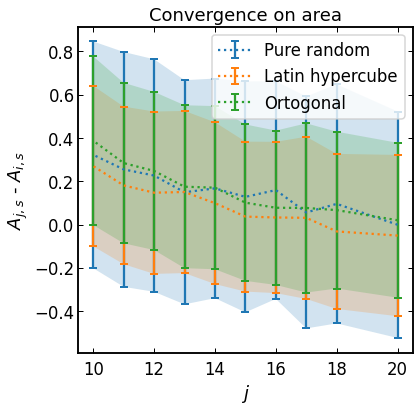

In [9]:
plt.errorbar(i_values, means_i_all_results[0], stds_i_all_results[0], fmt=':', capsize=4, capthick=2, label='Pure random')
plt.fill_between(i_values, means_i_all_results[0] - stds_i_all_results[0], means_i_all_results[0] + stds_i_all_results[0], alpha=0.2)
plt.errorbar(i_values, means_i_all_results[1], stds_i_all_results[1], fmt=':', capsize=4, capthick=2, label='Latin hypercube')
plt.fill_between(i_values, means_i_all_results[1] - stds_i_all_results[1], means_i_all_results[1] + stds_i_all_results[1], alpha=0.2)
plt.errorbar(i_values, means_i_all_results[2], stds_i_all_results[2], fmt=':', capsize=4, capthick=2, label='Ortogonal')
plt.fill_between(i_values, means_i_all_results[2] - stds_i_all_results[2], means_i_all_results[2] + stds_i_all_results[2], alpha=0.2)
plt.legend()
plt.title('Convergence on area')
plt.xlabel('$j$')
plt.ylabel('$A_{j, s}$ - $A_{i, s}$')
plt.show()

In [10]:
alpha = 0.05
p_uniform_lhc = f_test(areas_max_all_results[0], areas_max_all_results[1])
p_uniform_o = f_test(areas_max_all_results[0], areas_max_all_results[2])
p_lhc_o = f_test(areas_max_all_results[1], areas_max_all_results[2])

if p_uniform_lhc > alpha:
    print(f'Uniform and LHC have same variance with p = {p_uniform_lhc}')
else:
    print(f'Uniform and LHC do NOT have same variance with p = {p_uniform_lhc}')

if p_uniform_o > alpha:
    print(f'Uniform and Ortogonal have same variance with p = {p_uniform_o}')
else:
    print(f'Uniform and Ortogonal do NOT have same variance with p = {p_uniform_o}')

if p_lhc_o > alpha:
    print(f'LHC and Ortogonal have same variance with p = {p_lhc_o}')
else:
    print(f'LHC and Ortogonal do NOT have same variance with p = {p_lhc_o}')

Uniform and LHC do NOT have same variance with p = 0.0007124700126300046
Uniform and Ortogonal do NOT have same variance with p = 0.00943156045352806
LHC and Ortogonal have same variance with p = 0.19563896300102174
